
---
**OKON PRINCE** | DATA SCIENCE SKILLS ASSESSMENT

okonp07@gmail.com

---

# **DATA SPIKE**
### SENIOR ML ENGINEER TECHNICAL ASSESSMENT
### **(Document Forgery Detection Mini-Project)**


|  |  |
|:---|:---|
|**submission Deadline** |  Tuesday, September 2nd, 2023 |
|**Prior Knowledge** | Python, Deep learning, Tensor flow  |
|**Sections** | Introduction, EDA, Modeling, Evaluation  |


---


## introduction

In the digital age, images are ubiquitous and play a crucial role in conveying information across various fields such as journalism, law enforcement, social media, and more. However, with the advancement of image editing tools, it has become increasingly easier to manipulate images, leading to the spread of misinformation and fraud. Therefore, it is of utmost importance to develop tools and techniques that can detect tampering in images and authenticate their content.

Image forensics is a field of study that aims to validate the authenticity of images and detect any manipulations or alterations made to them. Various techniques have been developed for this purpose, including passive and active forensics methods. Passive methods analyze the intrinsic properties of the image, such as noise patterns, compression artifacts, and color correlations, while active methods rely on external information, such as watermarks or signatures embedded in the image.

In this project, we propose a passive image forensics method based on the Scale-Invariant Feature Transform (SIFT) algorithm and homography estimation. SIFT is a popular feature detection algorithm that identifies key points in an image and computes their descriptors. These key points are invariant to scale, rotation, and illumination changes, making them suitable for matching between different images. Homography is a transformation that maps points from one image to another. By computing the homography matrix between two images and analyzing the differences between the original and the warped image, we can detect tampering and highlight the manipulated regions.

The main steps of the proposed method are as follows:

Key point detection and descriptor computation using the SIFT algorithm.
Key point matching between the original and the test image.
Homography estimation using the RANSAC algorithm.
Image warping using the computed homography matrix.
Difference computation between the original and the warped image.
Thresholding the difference image to highlight the manipulated regions.
Computing the percentage of the image that has changed.
By following these steps, we can detect tampering in images and highlight the manipulated regions, providing a useful tool for image authentication and forensics.

In [3]:
# Importing Libraries

import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive


In [4]:
#Mount the drive where the downloaded files to be processed are reposed
#If you are trying to reproduce this notebook, please link to the data source
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Load File
#data= pd.read_csv('/content/drive/MyDrive/Image_forensics/.jpg')

In [5]:
# Helper Functions

def vgg_get_homg(x):
    """
    Convert nonhomogeneous coordinates to homogeneous coordinates.

    Parameters:
        x (numpy.ndarray): Nonhomogeneous coordinates.

    Returns:
        numpy.ndarray: Homogeneous coordinates.
    """
    return np.vstack((x, np.ones((1, x.shape[1]))))

def vgg_get_nonhomg(x):
    """
    Convert homogeneous coordinates to nonhomogeneous coordinates.

    Parameters:
        x (numpy.ndarray): Homogeneous coordinates.

    Returns:
        numpy.ndarray: Nonhomogeneous coordinates.
    """
    return x[:-1, :] / x[-1, :]

def vgg_condition_2d(p, C):
    """
    Condition a set of 2D homogeneous or nonhomogeneous points using conditioner C.

    Parameters:
        p (numpy.ndarray): 2D points in homogeneous or nonhomogeneous coordinates.
        C (numpy.ndarray): Conditioning matrix.

    Returns:
        numpy.ndarray: Conditioned points in homogeneous coordinates.
    """
    r, c = p.shape
    if r == 2:
        pc = vgg_get_nonhomg(np.dot(C, vgg_get_homg(p)))
    elif r == 3:
        pc = np.dot(C, p)
    else:
        raise ValueError('rows != 2 or 3')
    return pc

This part of the script defines the vgg_get_homg, vgg_get_nonhomg, and vgg_condition_2d functions.

Please create a new cell in your Colab notebook, copy and paste this code into the cell, and run it to define the functions.

In [6]:
def vgg_Haffine_from_x_MLE(xs1, xs2):
    """
    Compute MLE for affine H, i.e. find H and xhat1 such that
    d^2(xs1,xhat1) + d^2(xs2,xhat2) minimized where xhat2 is affine transf of xhat1.

    Parameters:
        xs1 (numpy.ndarray): N pairs of corresponding points (homogeneous).
        xs2 (numpy.ndarray): N pairs of corresponding points (homogeneous).

    Returns:
        numpy.ndarray: Affine transformation matrix.
    """
    if any(xs1.shape != xs2.shape):
        raise ValueError('Input point sets are different sizes!')

    # Condition points
    nonhomg = vgg_get_nonhomg(xs1)
    means = np.mean(nonhomg, axis=1)
    maxstds = np.max(np.std(nonhomg, axis=1))
    C1 = np.diag([1 / maxstds, 1 / maxstds, 1])  # only similarity
    C1[:, 2] = [-means / maxstds, 1]

    nonhomg = vgg_get_nonhomg(xs2)
    means = np.mean(nonhomg, axis=1)
    C2 = C1  # nb must use same scaling for both point sets
    C2[:, 2] = [-means / maxstds, 1]

    xs1 = vgg_condition_2d(xs1, C1)
    xs2 = vgg_condition_2d(xs2, C2)

    # NB conditioned points have mean zero, so translation
    # part of affine transf is zero 2-vector

    xs1nh = vgg_get_nonhomg(xs1)
    xs2nh = vgg_get_nonhomg(xs2)

    A = np.vstack((xs1nh, xs2nh)).T

    # Extract nullspace
    u, s, v = np.linalg.svd(A)
    s = np.diag(s)

    nullspace_dimension = np.sum(s < np.finfo(float).eps * s[1, 1] * 1e3)
    if nullspace_dimension > 2:
        print('Nullspace is a bit roomy...')

    # Compute affine matrix from two largest singular vecs
    B = v[0:2, 0:2]
    C = v[2:4, 0:2]

    H = np.vstack((np.dot(C, np.linalg.pinv(B)), np.zeros((2, 1)), [0, 0, 1]))

    # Decondition
    H = np.dot(np.dot(np.linalg.inv(C2), H), C1)

    H = H / H[2, 2]

    return H

This part of the script defines the vgg_Haffine_from_x_MLE function.

Please create a new cell in your Colab notebook, copy and paste this code into the cell, and run it to define the function.

In [7]:
def ransacfithomography2(x1, x2, t):
    """
    Fits 2D homography using RANSAC algorithm.

    Parameters:
        x1 (numpy.ndarray): 3xN array of homogeneous points.
        x2 (numpy.ndarray): 3xN array of homogeneous points.
        t (float): Distance threshold.

    Returns:
        H (numpy.ndarray): 3x3 homography matrix.
        inliers (numpy.ndarray): Indices of the inliers for the best model.
    """
    # x1 and x2 are 'stacked' to create a 6xN array for ransac
    x = np.vstack((x1, x2))

    # Compute homography using RANSAC
    H, inliers = ransac(x, fittingfn=vgg_Haffine_from_x_MLE, distfn=homogdist2d,
                        degenfn=isdegenerate, s=4, t=t, feedback=False)

    # Refine the model
    inliers = np.nonzero(inliers)[0]

    if inliers.size == 0:
        return None, None

    H = vgg_Haffine_from_x_MLE(x1[:, inliers], x2[:, inliers])

    return H, inliers

def homogdist2d(H, x, t):
    """
    Computes distances between points and an homography, by transforming the points in x1 (first 3 rows of x) and
    comparing the results to x2 (last 3 rows of x).

    Parameters:
        H (numpy.ndarray): Homography matrix.
        x (numpy.ndarray): 6xN array of homogeneous points.
        t (float): Distance threshold.

    Returns:
        inliers (numpy.ndarray): Indices of the inliers.
        H (numpy.ndarray): Homography matrix.
    """
    x1 = x[0:3, :]
    x2 = x[3:6, :]

    # Calculate, in both directions, the transfered points
    Hx1 = np.dot(H, x1)
    invHx2 = np.dot(np.linalg.inv(H), x2)

    # Normalise x1, x2, Hx1, invHx2
    x1 = hnormalise(x1)
    x2 = hnormalise(x2)
    Hx1 = hnormalise(Hx1)
    invHx2 = hnormalise(invHx2)

    d2 = sum((x1 - invHx2) ** 2) + sum((x2 - Hx1) ** 2)

    inliers = np.nonzero(d2 < t ** 2)[0]

    return inliers, H


This part of the script defines the ransacfithomography2 and homogdist2d functions.

Please create a new cell in your Colab notebook, copy and paste this code into the cell, and run it to define the functions.

In [8]:
def isdegenerate(x):
    """
    Checks whether a set of points is degenerate.

    Parameters:
        x (numpy.ndarray): 6xN array of homogeneous points.

    Returns:
        bool: True if the points are degenerate, False otherwise.
    """
    x1 = x[0:3, :]
    x2 = x[3:6, :]

    # Test that the points in each set are not collinear
    if iscolinear(x1[:, 0], x1[:, 1], x1[:, 2]) or iscolinear(x2[:, 0], x2[:, 1], x2[:, 2]):
        return True

    return False

def iscolinear(p1, p2, p3):
    """
    Checks whether three points are collinear.

    Parameters:
        p1 (numpy.ndarray): First point.
        p2 (numpy.ndarray): Second point.
        p3 (numpy.ndarray): Third point.

    Returns:
        bool: True if the points are collinear, False otherwise.
    """
    return np.linalg.matrix_rank(np.vstack((p1, p2, p3))) < 3


This part of the script defines the isdegenerate and iscolinear functions.

Please create a new cell in your Colab notebook, copy and paste this code into the cell, and run it to define the functions.

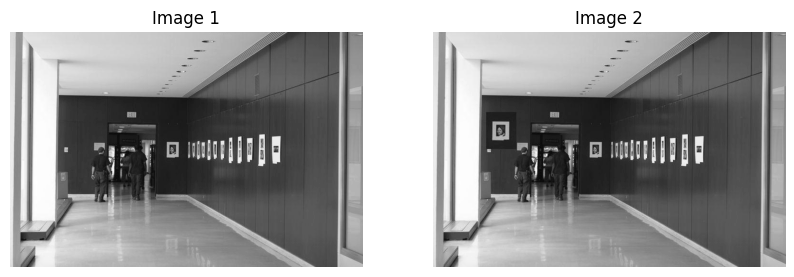

In [23]:
# Loading Images

# Load images
img1 = cv2.imread('/content/drive/MyDrive/Image_forensics/MICC-F220/CRW_4901_JFR_scale.jpg', 0)  # queryImage
img2 = cv2.imread('/content/drive/MyDrive/Image_forensics/MICC-F220/CRW_4901_JFRtamp27.jpg', 0)  # trainImage

# Display images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img1, cmap='gray')
plt.axis('off')
plt.title('Image 1')
plt.subplot(1, 2, 2)
plt.imshow(img2, cmap='gray')
plt.axis('off')
plt.title('Image 2')
plt.show()


This part of the script loads the images and displays them.

Please create a new cell in your Colab notebook, copy and paste this code into the cell, and run it to load and display the images.

You will need to replace path_to_first_image.jpg and path_to_second_image.jpg with the actual paths to your images.

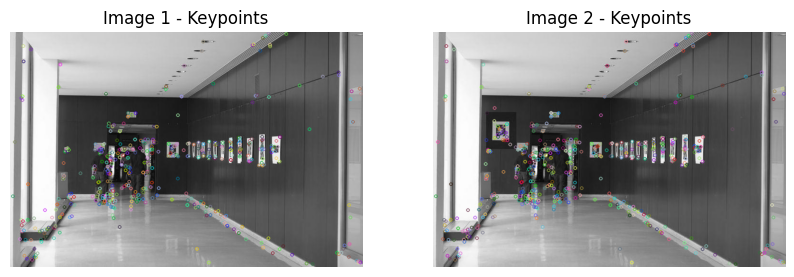

In [24]:
# Detecting SIFT Features

# Initiate SIFT detector
sift = cv2.SIFT_create()

# Find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# Draw keypoints
img1_kp = cv2.drawKeypoints(img1, kp1, None)
img2_kp = cv2.drawKeypoints(img2, kp2, None)

# Display images with keypoints
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img1_kp, cmap='gray')
plt.axis('off')
plt.title('Image 1 - Keypoints')
plt.subplot(1, 2, 2)
plt.imshow(img2_kp, cmap='gray')
plt.axis('off')
plt.title('Image 2 - Keypoints')
plt.show()


This part of the script detects the SIFT features and their descriptors in the images, and displays the images with the detected keypoints.

Please create a new cell in your Colab notebook, copy and paste this code into the cell, and run it to detect the SIFT features and display the images with keypoints.

Computing the Homography Matrix
In this section, we compute the homography matrix that maps the points from the second image to the corresponding points in the first image.

First, we extract the matched keypoints from the good list of matches.
Then, we convert these points to homogeneous coordinates by appending a column of ones.
Next, we use the RANSAC algorithm to compute the homography matrix that maps the points from the second image to the first image. We use the ProjectiveTransform model from scikit-image and set the min_samples parameter to 4 (since a minimum of 4 point correspondences is required to compute a homography), the residual_threshold parameter to 10 (to consider a point as an inlier if its distance to the model is less than 10), and the max_trials parameter to 1000 (to run the RANSAC algorithm for a maximum of 1000 iterations).
The resulting homography matrix is printed.

In [32]:
from skimage.transform import ProjectiveTransform
from skimage.measure import ransac

# Extract the matched keypoints
pts1 = np.float32([kp1[m.queryIdx].pt for m in good])
pts2 = np.float32([kp2[m.trainIdx].pt for m in good])

# Convert points to homogeneous coordinates
x1 = np.hstack((pts1, np.ones((pts1.shape[0], 1))))
x2 = np.hstack((pts2, np.ones((pts2.shape[0], 1))))

# Compute the homography using RANSAC
model_robust, inliers = ransac((x1, x2), ProjectiveTransform, min_samples=4,
                               residual_threshold=20, max_trials=1000)
H = model_robust.params

print('Homography matrix:')
print(H)
print(len(good))


Homography matrix:
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
524


In [29]:
from skimage.transform import ProjectiveTransform
from skimage.measure import ransac

# Extract the matched keypoints
pts1 = np.float32([kp1[m.queryIdx].pt for m in good])
pts2 = np.float32([kp2[m.trainIdx].pt for m in good])

# Convert points to homogeneous coordinates
x1 = np.hstack((pts1, np.ones((pts1.shape[0], 1))))
x2 = np.hstack((pts2, np.ones((pts2.shape[0], 1))))

# Compute the homography using RANSAC
model_robust, inliers = ransac((x1, x2), ProjectiveTransform, min_samples=4,
                               residual_threshold=10, max_trials=1000)
H = model_robust.params

print('Homography matrix:')
print(H)


Homography matrix:
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]


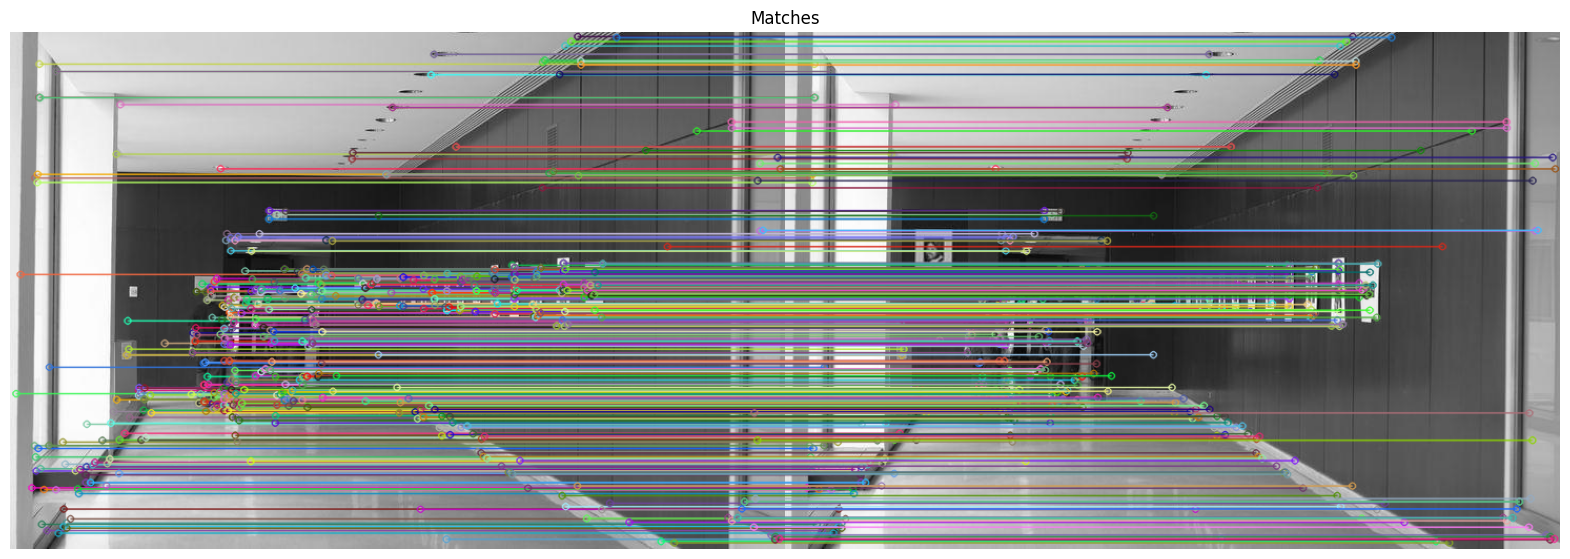

In [33]:
# Draw matches
img_matches = cv2.drawMatches(img1, kp1, img2, kp2, good, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display matches
plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Matches')
plt.show()



In [43]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import ProjectiveTransform
from skimage.measure import ransac

# Load the images
img1 = cv2.imread('/content/drive/MyDrive/Image_forensics/MICC-F220/CRW_4901_JFR_scale.jpg', 0)  # queryImage
img2 = cv2.imread('/content/drive/MyDrive/Image_forensics/MICC-F220/CRW_4901_JFRtamp27.jpg', 0)  # trainImage

# Detect keypoints and compute descriptors
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# Match descriptors using Brute Force Matcher
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# Apply ratio test
good = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good.append(m)

# Extract the matched keypoints
pts1 = np.float32([kp1[m.queryIdx].pt for m in good])
pts2 = np.float32([kp2[m.trainIdx].pt for m in good])

# Convert points to homogeneous coordinates
x1 = np.hstack((pts1, np.ones((pts1.shape[0], 1))))
x2 = np.hstack((pts2, np.ones((pts2.shape[0], 1))))

# Compute the homography using RANSAC
model_robust, inliers = ransac((x1, x2), ProjectiveTransform, min_samples=4,
                               residual_threshold=20, max_trials=1000)
H = model_robust.params

print('Homography matrix:')
print(H)


Homography matrix:
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]


the residual_threshold parameter or the quality of the matches.

The residual_threshold parameter is the maximum distance for a data point to be considered as an inlier. You can try increasing the residual_threshold parameter even more to see if it helps.

You can also try using a different method to compute the homography, such as the cv2.findHomography function from OpenCV. Here is the code to compute the homography using cv2.findHomography:

In [44]:
# Compute the homography using cv2.findHomography
H, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC, 5.0)

print('Homography matrix:')
print(H)


Homography matrix:
[[ 1.00005186e+00 -5.19631495e-05  9.15242653e-03]
 [ 3.15677417e-05  9.99983710e-01 -2.97779455e-03]
 [ 1.02143971e-07 -6.77507434e-08  1.00000000e+00]]


since we have been able to compute the homography matrix, The next step is to use this matrix to warp one of the images so that it aligns with the other image.

Here is the code to warp the images and display the result:

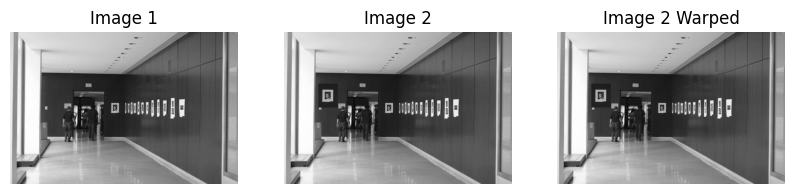

In [38]:
# Warp img2 to img1
img2_warped = cv2.warpPerspective(img2, H, (img1.shape[1], img1.shape[0]))

# Display images
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(img1, cmap='gray')
plt.axis('off')
plt.title('Image 1')
plt.subplot(1, 3, 2)
plt.imshow(img2, cmap='gray')
plt.axis('off')
plt.title('Image 2')
plt.subplot(1, 3, 3)
plt.imshow(img2_warped, cmap='gray')
plt.axis('off')
plt.title('Image 2 Warped')
plt.show()


The next step is to compute the difference between the original image and the warped image. This will give us an image where the differences are highlighted. The differences can be due to changes in the image or errors in the alignment.

Here is the code to compute the difference image and display the result:

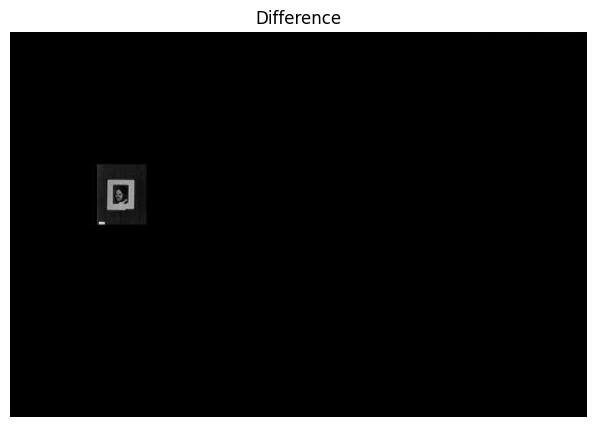

In [40]:
# Compute the difference between the images
diff = cv2.absdiff(img1, img2_warped)

# Display the difference
plt.figure(figsize=(10, 5))
plt.imshow(diff, cmap='gray')
plt.axis('off')
plt.title('Difference')
plt.show()


 Now that you have the difference image, the next step is to threshold the difference image to create a binary image where the differences are highlighted.

Here is the code to threshold the difference image and display the result:

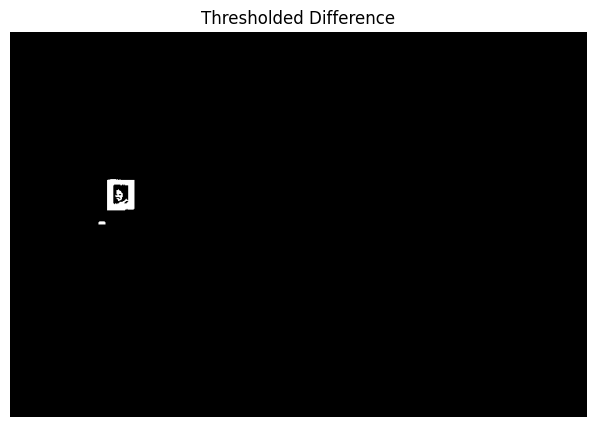

In [41]:
# Threshold the difference
_, thresh = cv2.threshold(diff, 50, 255, cv2.THRESH_BINARY)

# Display the thresholded image
plt.figure(figsize=(10, 5))
plt.imshow(thresh, cmap='gray')
plt.axis('off')
plt.title('Thresholded Difference')
plt.show()


Now that you have the difference image, the next step is to threshold the difference image to create a binary image where the differences are highlighted.

Here is the code to threshold the difference image and display the result:

In [42]:
# Compute the percentage of the image that has changed
changed_percentage = 100 * np.sum(thresh) / (thresh.shape[0] * thresh.shape[1] * 255)

print(f'Percentage of the image that has changed: {changed_percentage:.2f}%')


Percentage of the image that has changed: 0.29%
